# YOLOv5






## Импорт библиотек

In [1]:
# Для загрузки и анализа данных
import os
import tarfile
import urllib.request
import glob
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
#from tqdm import tqdm
from tqdm.notebook import tqdm, trange
from sklearn import preprocessing
from time import time

# Для работы с изображениями и построения модели
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageDraw
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,
                            Compose, GaussNoise)
import cv2
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import auc

# настройка визуализации
%matplotlib inline
plt.style.use('seaborn-v0_8')
%config InlineBackend.figure_format = "retina"

# для визуализации в tensorboard
%load_ext tensorboard

## Загрузка данных

К сожалению, по данной ссылке (`pjreddie.com`) у меня архив полностью не скачивается, поэтому я буду использовать эти же данные, но скачанные с `ultralytics`.

In [2]:
# Загрузка датасета
#if not os.path.exists("VOCdevkit"):
#    if not os.path.exists("VOC.tar"):
#        urllib.request.urlretrieve(
#            "https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar", "VOC.tar"
#        )
#    with tarfile.open("VOC.tar") as tar:
#        tar.extractall()

In [3]:
# Загрузка датасета
if not os.path.exists("/content/VOCdevkit"):
    urllib.request.urlretrieve(
        # ссылка на нужный нам раздел датасета VOC
        "https://github.com/ultralytics/yolov5/releases/download/v1.0/VOCtrainval_11-May-2012.zip",
        # название файла для сохранения в локальной среде
        "VOCtrainval_11-May-2012.zip"
    )

In [4]:
%%capture
# разархивируем скачанный датасет
!unzip VOCtrainval_11-May-2012.zip

## Подготовка данных

В представленном ноутбуке, в данной функции допущена ошибка (перепутаны оси) - исправлено в теле функции.

In [5]:
def xml_to_csv(path = 'VOCdevkit/VOC2012/Annotations/'):
    """
    Функция принимает на вход путь к файлам аннотаций (*.xml),
    возвращает датафрейм с названиями файлов, размерностью по 3 осям,
    названием класса, координаты рамки (bbox).
    """
    xml_list = []
    for xml_file in tqdm(glob.glob(path + '/2010*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for obj in root.findall('object'):
            bbx = obj.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = obj.find('name').text

            value = (root.find('filename').text,

                     # неправильная последовательность осей!
                     #int(root.find('size')[0].text),
                     #int(root.find('size')[1].text),
                     #int(root.find('size')[2].text),

                     # правильная последовательность осей!
                     int(root.find('size')[0].text),
                     int(root.find('size')[2].text),
                     int(root.find('size')[1].text),

                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'channels', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

Используя аннотации датасета, получим датафрейм с информацией: названия файлов, размерность по 3 осям, название класса объекта, координаты рамки (bbox).

In [6]:
xml_df = xml_to_csv()
xml_df.to_csv('VOC_2010.csv', index=None)
print('Конвертация прошла успешно.')

  0%|          | 0/3503 [00:00<?, ?it/s]

Конвертация прошла успешно.


Отберем первые 100 объектов в полученном датафрейме.

In [7]:
xml_df = xml_df[:100]

In [8]:
xml_df.head()

,filename,channels,width,height,class,xmin,ymin,xmax,ymax
0,2010_004621.jpg,3,331,500,cat,19,100,328,478
1,2010_004621.jpg,3,331,500,cat,253,99,331,346
2,2010_001070.jpg,3,375,500,cat,128,159,268,315
3,2010_006050.jpg,3,500,377,tvmonitor,2,85,18,175
4,2010_006050.jpg,3,500,377,tvmonitor,1,20,76,106


In [9]:
print(f'Общее количество объектов {xml_df.shape[0]}')
print(f'Количество изображений в датафрэйме {len(np.unique(xml_df["filename"]))}')

Общее количество объектов 100
Количество изображений в датафрэйме 44


## Обработка данных

Закодируем классы обьектов.

In [10]:
le = preprocessing.LabelEncoder()
xml_df['class'] = le.fit_transform(xml_df['class'])

In [11]:
xml_df.head()

,filename,channels,width,height,class,xmin,ymin,xmax,ymax
0,2010_004621.jpg,3,331,500,5,19,100,328,478
1,2010_004621.jpg,3,331,500,5,253,99,331,346
2,2010_001070.jpg,3,375,500,5,128,159,268,315
3,2010_006050.jpg,3,500,377,15,2,85,18,175
4,2010_006050.jpg,3,500,377,15,1,20,76,106


Сохраним кодировку классов в переменной mapping.

In [12]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))

In [13]:
mapping

{'aeroplane': 0,
 'bird': 1,
 'boat': 2,
 'bottle': 3,
 'car': 4,
 'cat': 5,
 'chair': 6,
 'diningtable': 7,
 'dog': 8,
 'motorbike': 9,
 'person': 10,
 'pottedplant': 11,
 'sheep': 12,
 'sofa': 13,
 'train': 14,
 'tvmonitor': 15}

Теперь нам нужно привести наши данные к формату **YOLOv5**.

Аннотация каждого объекта должна сожержать следующую информацию:

`Class X Y Width Height`

![picture](https://drive.google.com/uc?export=view&id=1yUJt5XTvYo4MbWxKAxhPdCk-yCnQ1AEz)


Для этого воспользуемся вспомогательной функцией `convert_to_yolov5`.



In [14]:
def convert_to_yolov5(df, unique_img_names):
    """
    Функция принимает на вход датафрейм с информацией о файлах картинок:
    имя файла, размерность по 3 осям, метка класса, координаты ограничительной рамки (bbox),
    и уникальные имена файлов с картинками (т.к. одна картинка может содержать несколько объектов).
    Функция преобразует аннотации, полученные из датафрейма в формат для модели YOLO и сохраняет их
    на диск в виде файлов.
    """

    df_array = np.array(df)

    # Для каждого объкта
    for i in range(len(df)):
        print_buffer = []

        point =  df_array[i]
        img_name = point[0]

        # Для каждого уникального изображения
        for unique_img_name in unique_img_names:
           if img_name == unique_img_name:
              class_id = point[4]

              # Преобразуем координаты bbox
              X = (point[5] + point[7]) / 2
              Y = (point[6] + point[8]) / 2
              Width    = (point[7] - point[5])
              Height   = (point[8] - point[6])

              # Нормализуем координаты
              image_c, image_w, image_h = point[1], point[2], point[3]
              X /= image_w
              Y /= image_h
              Width    /= image_w
              Height   /= image_h

              # Запишем информацию о bbox в файл
              print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, X, Y, Width, Height))

        # Дадим имя файлам, которые хотим сохранить
        save_file_name = os.path.join("/content/VOCdevkit/VOC2012/JPEGImages/", img_name.replace("jpg", "txt"))

        # Сохраним аннотации на диск
        print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [15]:
# Для начала выделим список уникальных имен изображений
unique_img_names = xml_df['filename'].unique()
print(len(unique_img_names))

44


In [16]:
# Получим аннотации в новом формате
convert_to_yolov5(xml_df, unique_img_names)

Давайте протестируем трансформированные аннотации с помощью визуализации.

In [17]:
class_id_to_name_mapping = dict(zip(mapping.values(), mapping.keys()))

In [18]:
def plot_bounding_box(image, annotation_list):
    """
    Функция принимает на вход изображение и аннотации к ней,
    выводит изображение и ограничительные рамки для объекта,
    а также название класса объекта.
    """

    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    print(transformed_annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))

        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))], fill="#000")

    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.array(image))
    plt.show()

In [19]:
# Выберем рандомную аннотацию
annotation_random= !ls /content/VOCdevkit/VOC2012/JPEGImages/*txt | shuf -n 1

In [20]:
annotation_random

['/content/VOCdevkit/VOC2012/JPEGImages/2010_005684.txt']

In [21]:
# Выберем рандомную аннотацию
annotation_file = annotation_random[0]
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

Output hidden; open in https://colab.research.google.com to view.

Обученная модель находится в классе hub библиотеки `torch`.

Давайте посмотрим на предсказания модели для нашей рандомной картинки.

In [22]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

img = annotation_random[0].replace("txt", "jpg")

# Inference
results = model(img)

# Results
results.print()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


requirements: Ultralytics requirement ['gitpython>=3.1.30'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 213.4 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 5.9s, installed 1 package: ['gitpython>=3.1.30']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2024-2-7 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 40.9MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1: 357x500 1 person, 1 motorcycle
Speed: 23.0ms pre-process, 162.4ms inference, 868.8ms NMS per image at shape (1, 3, 480, 640)


**Выводы:** На представленном изображении мы видим мотоциклиста (класс person, bbox отмечены на изображении), и мотоцикл (класс motorcycle).

# ЗАДАНИЕ

Обучите модель **yolov5**,  используя готовый `train.py` файл репозитория https://github.com/ultralytics/yolov5.git.

Для данной модели изображения и классы объектов должны находиться в папках images и labels, соответсвенно.

Протестируйте модель на валидациооной выборке и выведите на экран полученные изображения с bbox и классами объектов.

Сделайте сравнение текущей модели с Faster RCNN по скорости и качетсву.

# Решение

Решение реализовано в Google Colab Pro.

## YOLOV5

В задании указано использовать `train.py` проекта **yolov5**, следоваетльно данный проект необходимо клонировать в нашу среду обучения.  

Для визуализации логов может использоваться (по желанию) CometML, Tensorboard. Я же использовал встроенные возможности Yolov5 для визуализации результатов обучения.   

Для обучения будем использовать файл VOC_project.yaml, который является отредактированной версией файла VOC.yaml оригинального датасета VOC:
- используется только один раздел оригинального датасета *VOCtrainval_11-May-2012*
- используется только разделы *train* и *val*

Как может быть отмечено, я в настройках .yaml сохранил раздел, который отвечает за скачивание датасета, хотя мы его уже скачали выше. К сожалению я не смог скормить скачанный выше датасет нашей модели, даже перенося его в каталог по умолчанию, откуда модель принимает данные.   
  
В задании указано использовать метрику `accuracy`, значение которой на валидационной выборке должно превысить 0.85. Проблема заключается в том, что исходный код **yolov5** не расчитывает данную метрику. Я решил проблему следующим образом:
- будет расчитана метрика accuracy с использованием значений ConfusionMatrix, которая реализована в **yolov5**. Расчитывать будем 2 способами (за подсказку благодарю своего ментора Марию Жарову :) ):
  - `accuracy_total` (общая) будет расчитана как сумма значений главной диагонали ConfusionMatrix (по сути, это сумма TP), разделенная на сумму всех значений матрицы. Другими словами, TP-детекции (в сумме) разделим на все детекции.
  - `accuracy_mean` (средняя) будет расчитана, как средняя от всех построчных `accuracy` нашей ConfusionMatrix, то есть взята средняя от `accuracy` по всем классам. Построчная `accuracy` будет расчитана, как отношение значения ячейки строки, принадлежащей главной диагонали (это есть TP) к сумме значений всей строки матрицы.
  - для упрощения не будем брать в расчет `background`
- расчет `accuracy` будет реализован в виде кода в файле `yolov5/utils/metrics.py` (его надо заменить на файл `metrics.py` моего репозитория)
- значение метрики `accuracy` будет добавлено в заглавие изображения ConfusionMatrix, которое будет сохраняться после каждого эксперимента в папке `yolov5/runs` в соответствующих разделах.

Клонируем репозиторий **yolov5** и устанавливаем зависимости:

In [23]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt comet_ml

Cloning into 'yolov5'...
remote: Enumerating objects: 16413, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 16413 (delta 0), reused 4 (delta 0), pack-reused 16408
Receiving objects: 100% (16413/16413), 14.95 MiB | 19.98 MiB/s, done.
Resolving deltas: 100% (11260/11260), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.6/601.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.7/514.7 kB 44.7 MB/s eta 0:00:00


Проверим выделенные ресурсы (`utils` надо импортировать после клонирования репозитория, а не устанавливать до, иначе возможны конфликты):

In [24]:
import utils
display = utils.notebook_init()

YOLOv5 🚀 2024-2-7 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)


Setup complete ✅ (8 CPUs, 51.0 GB RAM, 30.2/166.8 GB disk)


Если используем CometML (надо ввести имя проекта и api-key):

In [25]:
# импортируем comet_ml и инициализируем начало эксперимента

#import comet_ml
#experiment = comet_ml.Experiment(
#    api_key="<ваш_api_key>",
#    project_name="<имя_проекта>"
#)
#comet_ml.init(project_name='voc')
#!export COMET_API_KEY="<ваш_api_key>"

Запускаем процесс обучения на тренировочной выборке (воспользуемся предобученной моделью yolov5, которую мы уже скачали выше и обновленным файлом .yaml оригинального датасета):

In [25]:
!python train.py --img 640 --batch 16 --epochs 3 --data /content/VOC_project.yaml --weights /content/yolov5s.pt --cache

2024-02-07 19:21:25.967260: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 19:21:25.967317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 19:21:25.968778: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=/content/yolov5s.pt, cfg=, data=/content/VOC_project.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=3, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, 

Был повторно скачан необходимый нам раздел орининального датасета VOC, который был разделен на тренировочную и валидационную выборки. Процесс обучения прошел успешно, выполнена валидация, получены метрики. Также были сохранены последние и лучшие веса дообученной модели. Сохранены логи CometML.

К сожалению, я не совсем разобрался, прошла ли валидация на отдельной валидационной выборке или для валидации использовалась только тренировочная выборка (почему-то, все результаты сохранились в раздел train). Поэтому, думаю, что будет правильно запустить отдельно валидацию на валидационной выборке и пересчитать метрики.

In [26]:
!python val.py --weights runs/train/exp/weights/best.pt --data /content/VOC_project.yaml --img 640

val: data=/content/VOC_project.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-283-g875d9278 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)

Fusing layers... 
Model summary: 157 layers, 7064065 parameters, 0 gradients, 15.9 GFLOPs
val: Scanning /content/datasets/VOC/labels/val2012.cache... 5823 images, 0 backgrounds, 0 corrupt: 100% 5823/5823 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 182/182 [00:49<00:00,  3.68it/s]
                   all       5823      13841      0.715      0.653      0.708      0.403
             aeroplane       5823        433      0.701      0.721      0.716      0.295
     

Разница получилась несущественная, однако результаты сохранены уже в раздел val.

Если используем CometML, то отмечаем завершение эксперимента и выводим полученные результаты:

In [28]:
#experiment.end()

In [29]:
#experiment.display(tab="<имя_проекта>")

Если используем Tensorboard, то визуализируем результаты:

In [30]:
#%tensorboard --logdir /content/yolov5/runs

Теперь выполним детекцию валидационной выборки:

In [27]:
%%capture
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --conf 0.25 --source /content/datasets/VOC/images/val2012

Выведем случайную картинку с bbox после детекции:

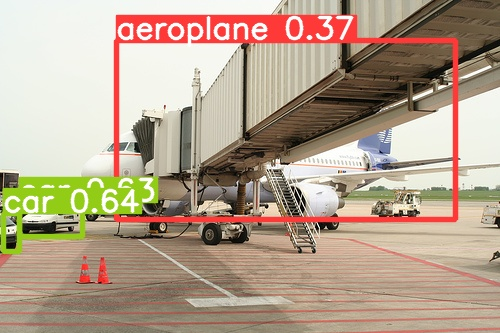

In [29]:
random_img = !ls /content/yolov5/runs/detect/exp/*jpg | shuf -n 1 | shuf -n 1
display.Image(filename=random_img[0], width=600)

Выведем метрики:

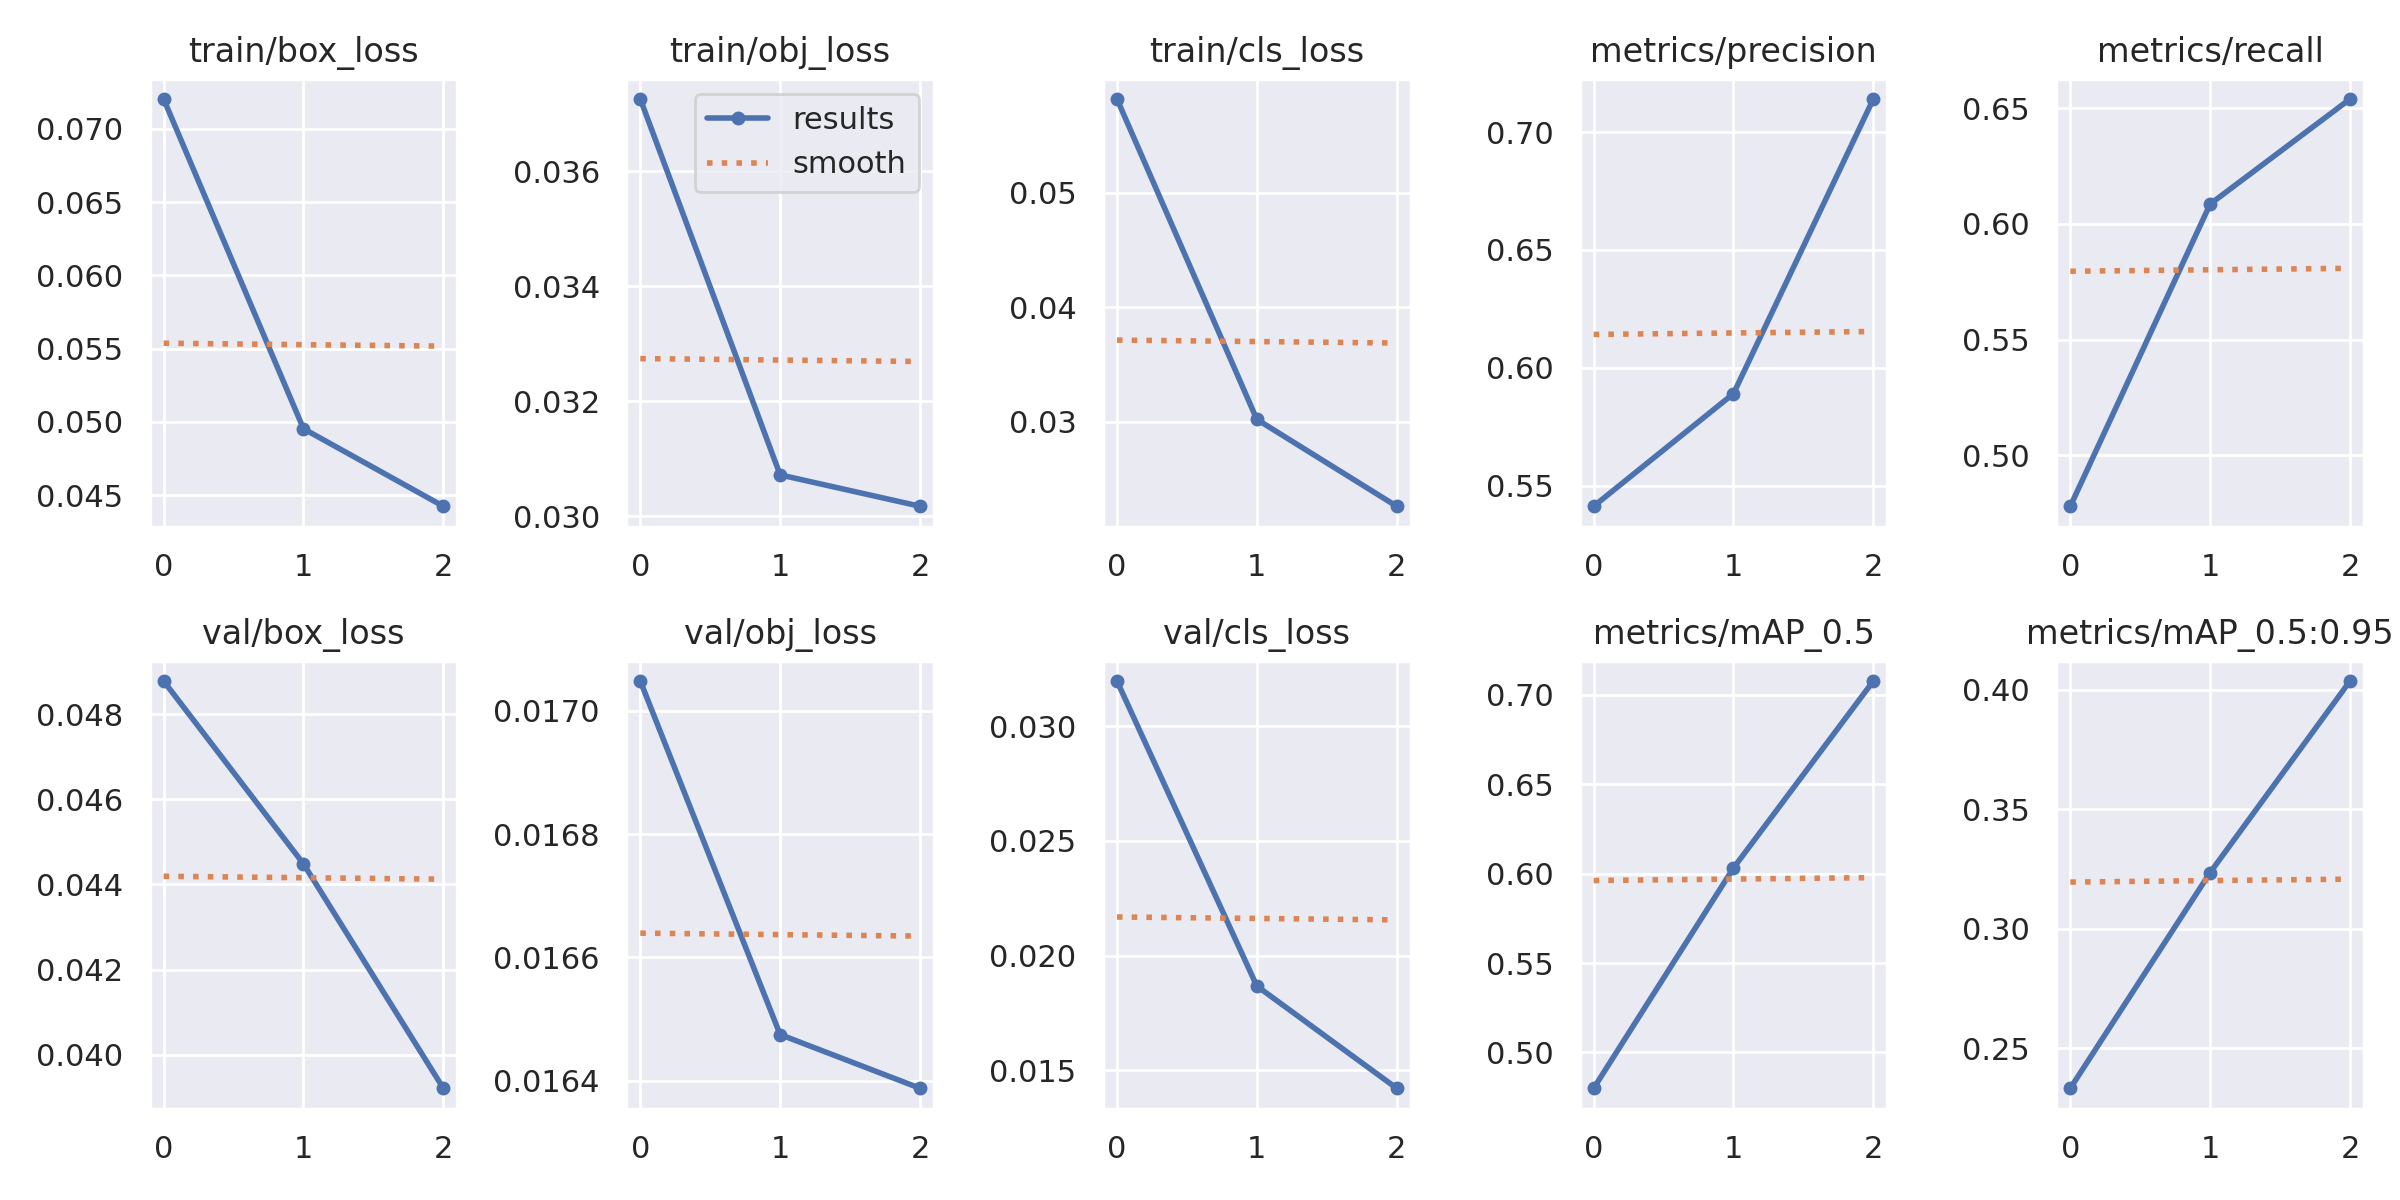

In [30]:
display.Image(filename='/content/yolov5/runs/train/exp/results.png', width=1000)

Выведем ConfusionMatrix (в заглавии будет указано значение Accuracy):

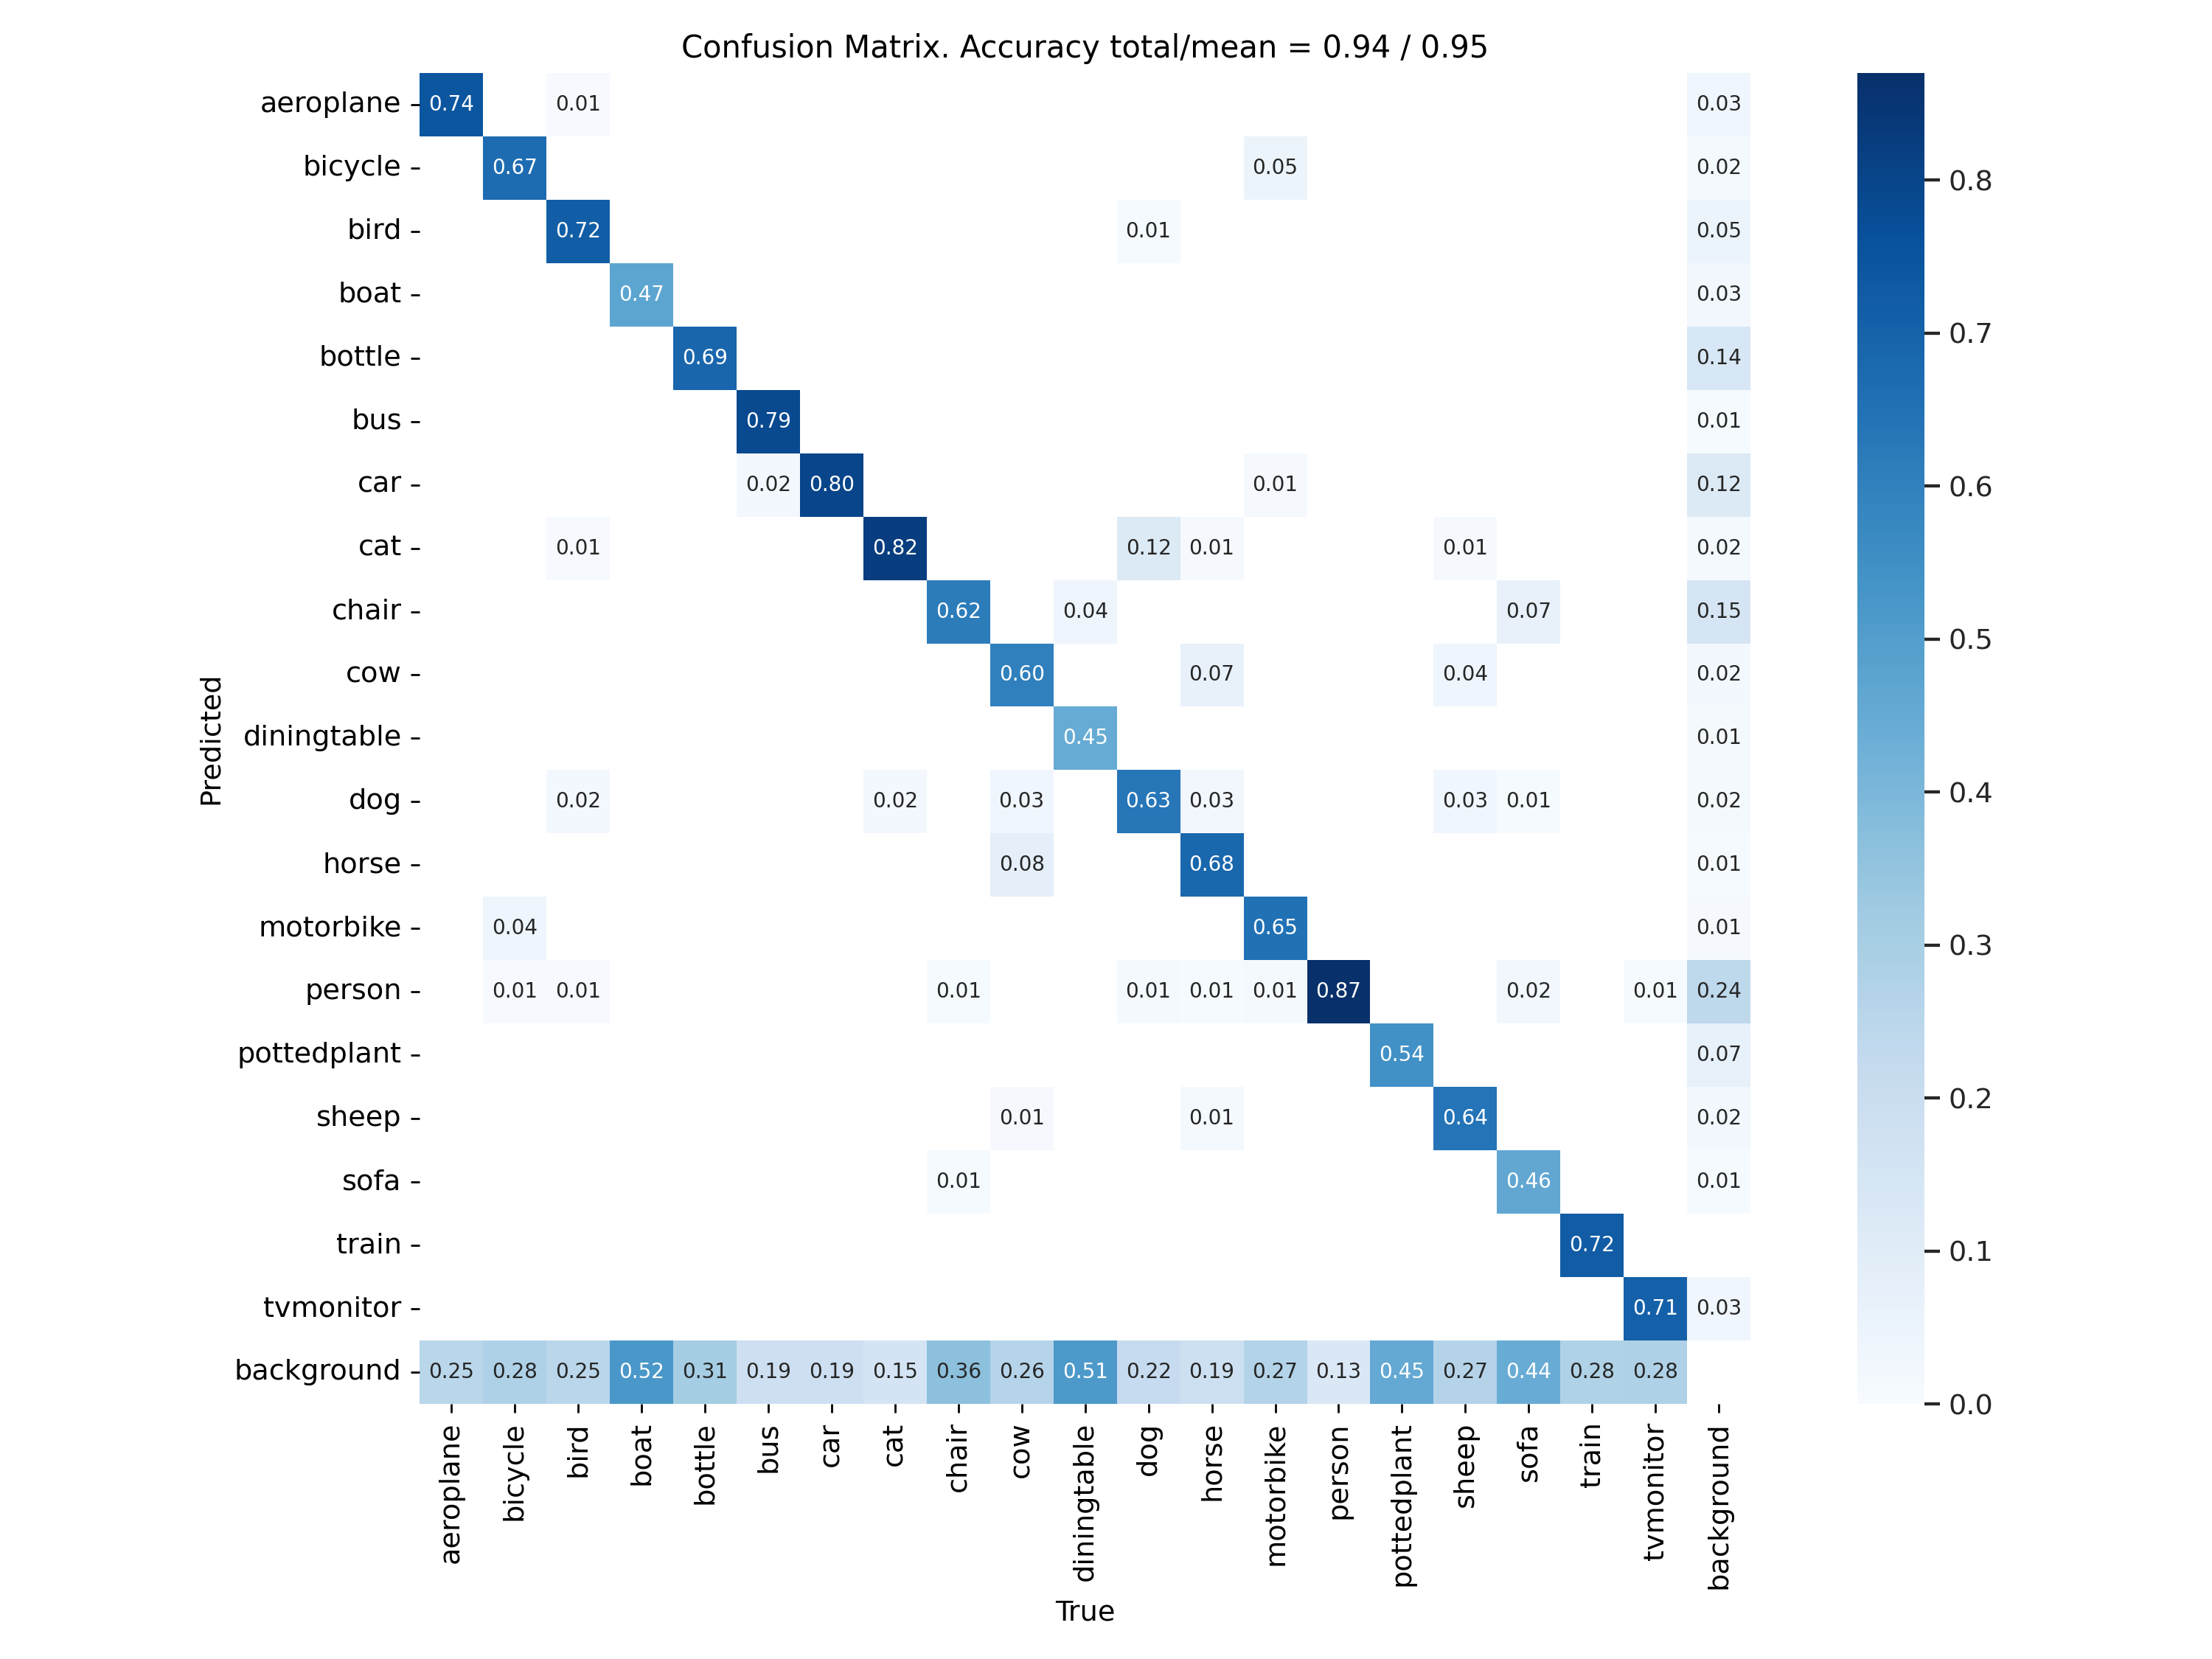

In [31]:
display.Image(filename='/content/yolov5/runs/val/exp/confusion_matrix.png', width=1000)

Мы достигли показателя Accuracy > 0.85, однако давайте выведем батч данных с разметкой и предсказаниями:

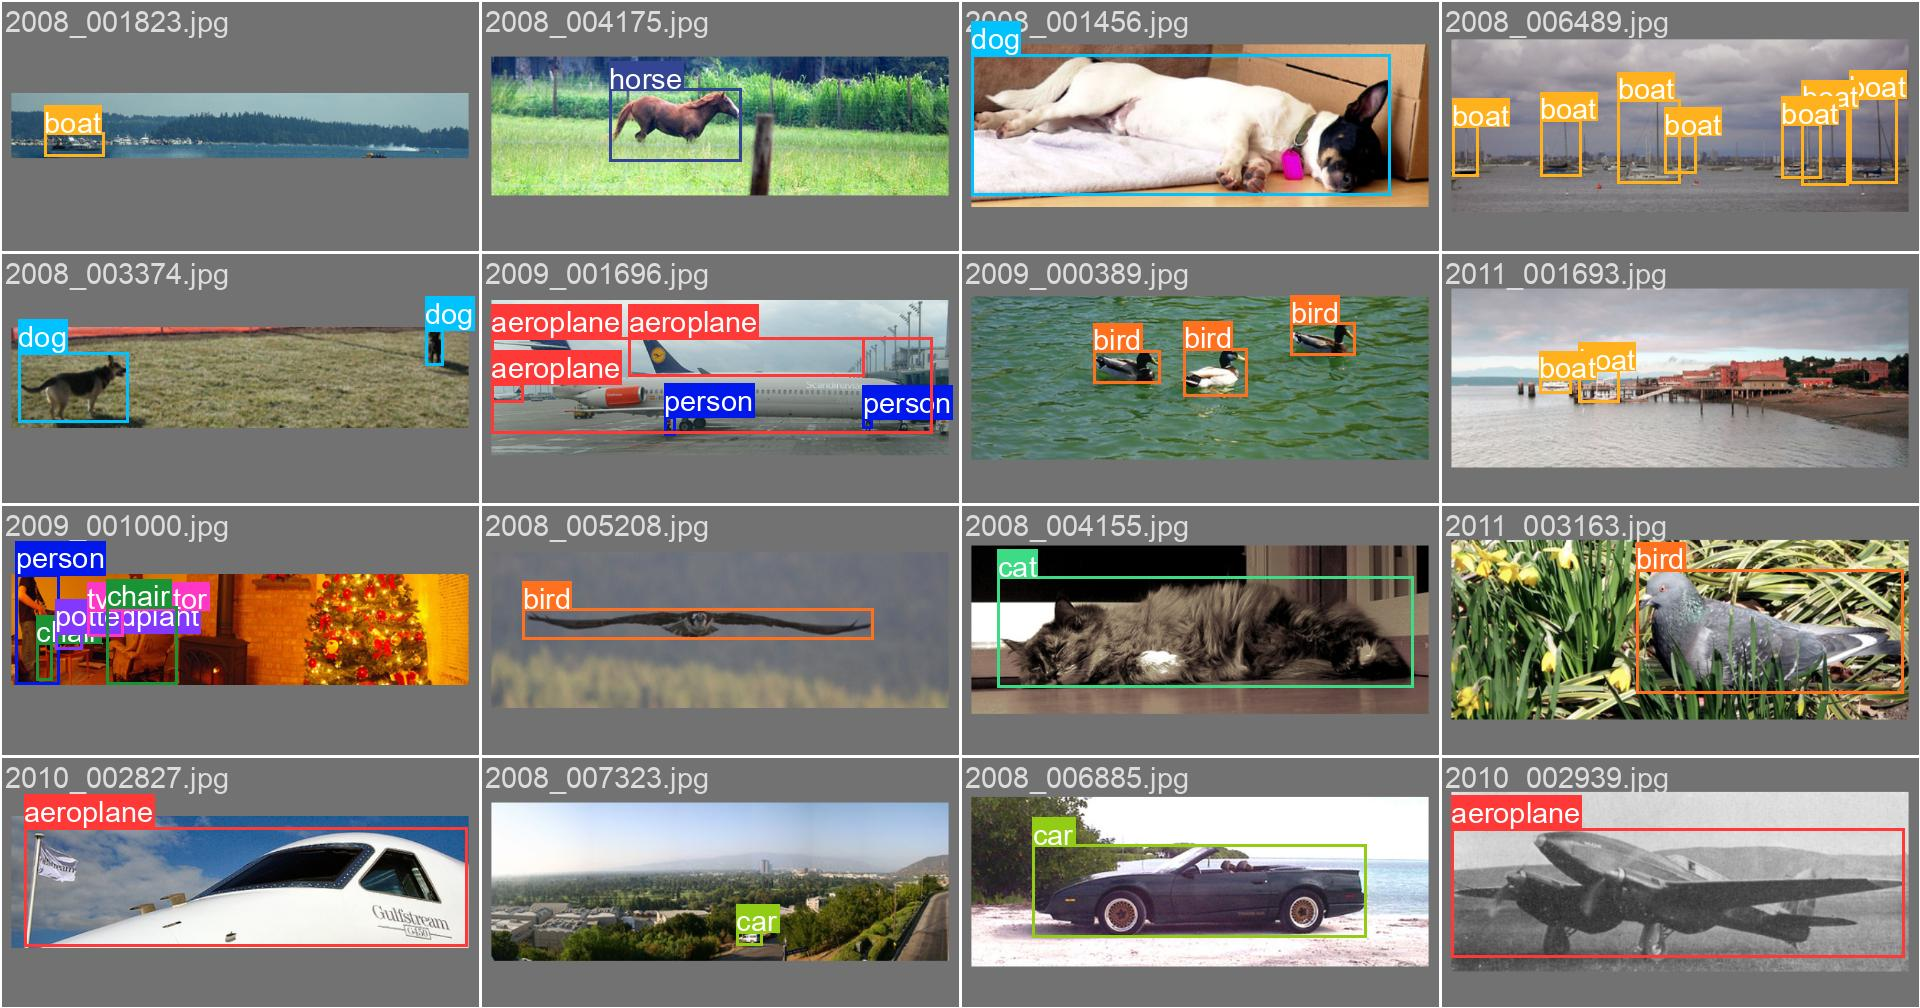

In [32]:
display.Image(filename='/content/yolov5/runs/val/exp/val_batch0_labels.jpg', width=1000)

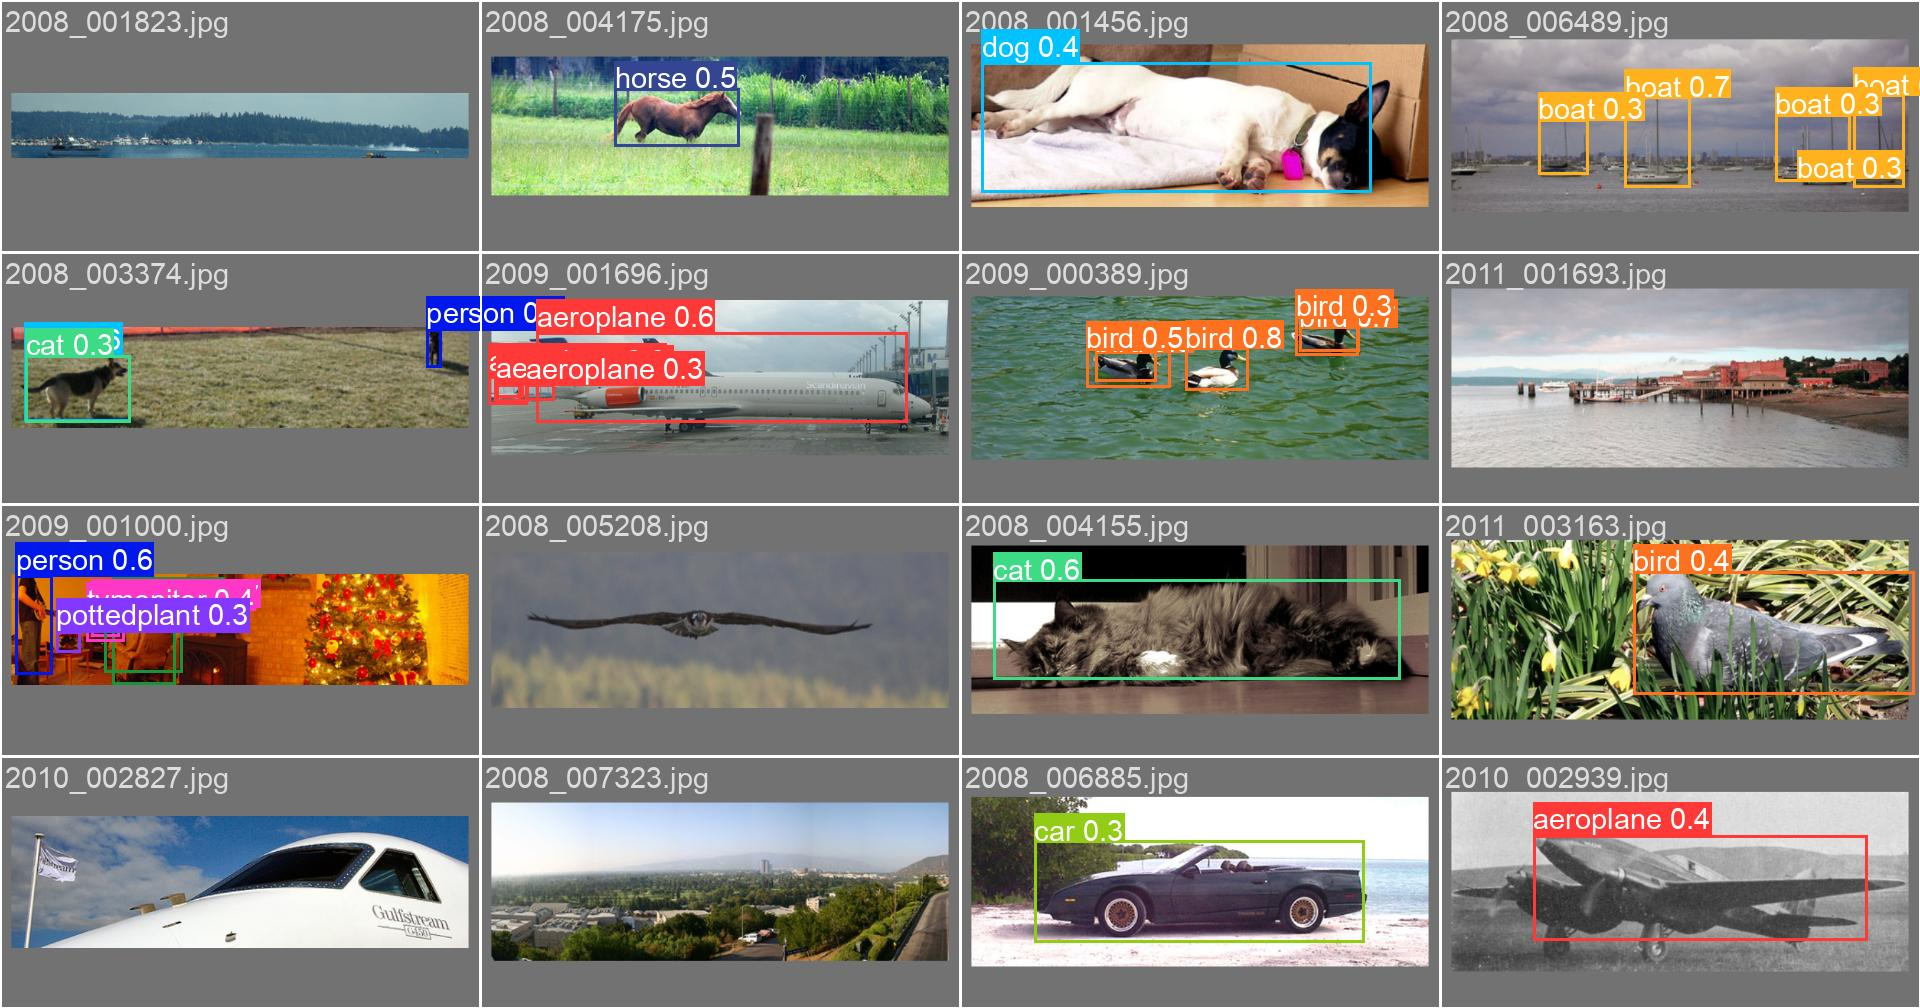

In [33]:
display.Image(filename='/content/yolov5/runs/val/exp/val_batch0_pred.jpg', width=1000)

**Выводы:**
- условия задания выполнены, формально достигнут показатель `accuracy` = 0.94 - 0.95 на 3-х эпохах по всему датасету
- не смотря на высокий показатель данной метрики, результаты работы модели на валидационной выборке не столь идеальны
- более адекватными метриками для оценки работы нашей модели являются, на мой взгляд, mAP, Precision, Recall

## Faster RCNN

 Отберем 1000 объектов из нового датафрейма (если обучать модель по всей выборке, то памяти видеокарты V100 не хватает).     
Процесс обучения и валидации модели реализован с помощью данных источников:
- [Семинар 6. Семантическая сегментация, детекция.](https://colab.research.google.com/github/hse-ds/iad-deep-learning/blob/master/2021/seminars/sem06/sem_06.ipynb#scrollTo=5Pkva3QFDDed)
- [Intersection over Union (IoU) in Object Detection & Segmentation](https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/)

Для оценки модели на валидации будем использовать метрику mAP.

### Подготовка данных

In [34]:
%cd /content/

/content


Обновим функцию `xml_to_csv` (поменяем оси):

In [35]:
def xml_to_csv(path = 'VOCdevkit/VOC2012/Annotations/'):
    """
    Функция принимает на вход путь к файлам аннотаций (*.xml),
    возвращает датафрейм с названиями файлов, размерностью по 3 осям,
    названием класса, координаты рамки (bbox).
    """
    xml_list = []
    for xml_file in tqdm(glob.glob(path + '/2010*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for obj in root.findall('object'):
            bbx = obj.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = obj.find('name').text

            value = (root.find('filename').text,

                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     int(root.find('size')[2].text),

                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'channels', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

Заново создадим датафрейм с данными по изображениям и объектам.

In [36]:
xml_df = xml_to_csv()
xml_df.to_csv('VOC_2010_frcnn.csv', index=None)
print('Successfully converted xml to csv.')

  0%|          | 0/3503 [00:00<?, ?it/s]

Successfully converted xml to csv.


Отберем только 1000 сэмплов для упрощения обучения модели

In [37]:
xml_df = xml_df[:1000]
print(f'Общее количество объектов {xml_df.shape[0]}')
print(f'Количество изображений в датафрэйме {len(np.unique(xml_df["filename"]))}')

Общее количество объектов 1000
Количество изображений в датафрэйме 451


Кодируем классы:

In [38]:
le = preprocessing.LabelEncoder()
xml_df['class'] = le.fit_transform(xml_df['class'])

Разделим выборку на train и val:

In [39]:
image_ids = xml_df['filename'].unique()
train_ids = image_ids[0:int(0.8*len(image_ids))]
val_ids = image_ids[int(0.8*len(image_ids)):]
print(f'# изображение {len(image_ids)}')
print(f'# train изображений {len(train_ids)}')
print(f'# val изображений {len(val_ids)}')

# изображение 451
# train изображений 360
# val изображений 91


In [40]:
train_df = xml_df[xml_df['filename'].isin(train_ids)]
val_df = xml_df[xml_df['filename'].isin(val_ids)]

Вспомогательная функция для аугментации данных:

In [41]:
def get_transforms(phase):
    """
    Функция принимает на вход значение phase и возвращает
    трансформации для указанного датасета
    """
    list_transforms = []
    if phase == 'train':
        list_transforms.extend([
            Flip(p=0.5)
                              ])
    list_transforms.extend([
            ToTensorV2(),
                ])
    list_trfms = Compose(list_transforms,
        bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    return list_trfms

Напишем класс VOC_2010() для загрузки данных в модель:

In [42]:
class VOC_2010(Dataset):
    def __init__(self, df, image_dir, phase='train'):
        super().__init__()
        self.df = df
        self.image_dir = image_dir
        self.images = df['filename'].unique()
        self.transforms = get_transforms(phase)


    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        image = self.images[idx]
        image_id = str(image.split('.')[0])

        image_arr = cv2.imread(os.path.join(self.image_dir,image), cv2.IMREAD_COLOR)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)

        # Нормализация данных
        image_arr /= 255.0

        point = self.df[self.df['filename'] == image]
        boxes = point[['xmin', 'ymin', 'xmax', 'ymax']].values

        # Площадь внутри bbox
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # Запишем класс объекта в переменную label
        labels = torch.as_tensor(point['class'].values, dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor(idx)
        target['area'] = area

        if self.transforms:
            sample = {
                'image': image_arr,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']

        target['boxes'] = torch.stack(tuple(map(torch.tensor,
                                                zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

Укажем путь к данным и определим тренировочную и валидационную выборки:

In [43]:
train_dir = 'VOCdevkit/VOC2012/JPEGImages/'

train_data = VOC_2010(train_df, train_dir, phase='train')
val_data = VOC_2010(val_df, train_dir, phase='validation')

print(f'Размер обучающей выборки {len(train_data)}')
print(f'Размер валидационной выборки {len(val_data)}')

Размер обучающей выборки 360
Размер валидационной выборки 91


Определим размер батча и даталоадеры:

In [44]:
batch = 4

def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_data,
    batch_size=batch,
    shuffle=False,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    val_data,
    batch_size=batch,
    shuffle=False,
    collate_fn=collate_fn
)

Визуализируем данные:

In [45]:
def image_convert(image):
    """
    Фуонкция принимает на вход изображение, выполняет необходимые
    преобразования для визуализации и возвращает преобразованное
    изображение
    """
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data,idx):
    """
    Фуонкция принимает на вход выборку с изображениями и индекс,
    выводит изображение с bbox
    """
    img = data.__getitem__(idx)
    image = image_convert(img[0])
    image = np.ascontiguousarray(image)
    bbox = img[1]['boxes'].numpy()
    for i in bbox:
        cv2.rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), (0,255,0), thickness=2)
    plt.figure(figsize=(5,5))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)

In [46]:
plot_img(train_data,5)

Отрисуем 1 батч изображений с bbox.

In [47]:
# получаем батч из даталоадера
batch_data = next(iter(train_data_loader))

# получаем размер батча (в нашем случае 4)
batch_size = len(batch_data[0])

# задаем фигуру с изображениями
fig, axes = plt.subplots(1, batch_size, figsize=(batch_size * 5, 5))

# проходим по элементам батча
for i in range(batch_size):

    # получаем картинку (точнее тензор)
    img = batch_data[0][i]
    img = torchvision.utils.make_grid(img)

    # выполняем необходимые преобразования над изображением
    image = image_convert(img)
    image = np.ascontiguousarray(image)

    # получаем и отмечаем bbox
    bbox = batch_data[1][i]['boxes'].numpy()
    for x in bbox:
        cv2.rectangle(image, (int(x[0]),int(x[1])), (int(x[2]),int(x[3])), (0,255,0), thickness=2)

    # выводим изображение
    axes[i].imshow(image)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.show();

**Примечание:** Можно заметить, что последние 2 ячейки выполнились, однако изображения мы не получили. Если запусть раздел ноутбука Faster CNN, без запуска YOLO, то ячейки выведут изображения. Вероятно какой-то баг Google Colab, тут я не разобрался.

### Загрузка и настройка модели:

In [48]:
# загрузим предобученную модель
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# определим устройство
device = torch.device('cuda')

# определим число классов
num_classes = len(np.unique(xml_df['class']))
print(f'\nЧисло классов: {num_classes}')

# Получим число входных признаков для классификатора
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Заменим классификатор на новый
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:10<00:00, 16.7MB/s]


Число классов: 20


In [49]:
images, targets, ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [50]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005)

### Напишем функции для обучения и валидации модели

In [51]:
def intersection_over_union(dt_bbox: np.array, gt_bbox: np.array) -> float:
    """
    Функция принимает на вход 2 массива с координатами bbox, где
    dt_bbox - предсказанные координаты
    gt_bbox - реальные координаты
    Функция возвращает IOU (Intersection Over Union)

    Intersection over Union между 2 bboxes
    (x0, y0) - координаты верхнего левого угла
    (x1, y1) - координаты нижнего правого угла

    :param dt_bbox: список или массив размерности (4,) [x0, y0, x1, y1]
    :param gt_bbox: список или массив размерности (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """
    # координаты области пересечения
    ix1 = np.maximum(gt_bbox[0], dt_bbox[0])
    iy1 = np.maximum(gt_bbox[1], dt_bbox[1])
    ix2 = np.minimum(gt_bbox[2], dt_bbox[2])
    iy2 = np.minimum(gt_bbox[3], dt_bbox[3])

    # высота и ширина пересечения
    i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
    i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))

    area_of_intersection = i_height * i_width

    # размеры реального bbox
    gt_height = gt_bbox[3] - gt_bbox[1] + 1
    gt_width = gt_bbox[2] - gt_bbox[0] + 1

    # размеры предсказанного bbox
    pd_height = dt_bbox[3] - dt_bbox[1] + 1
    pd_width = dt_bbox[2] - dt_bbox[0] + 1

    area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection

    iou = area_of_intersection / area_of_union

    return iou

In [52]:
def evaluate_sample(target_pred: torch.Tensor, target_true, iou_threshold=0.5):
    # правильные прямоугольники
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    # предсказания модели
    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    # для каждого прямоугольника из предсказания находим максимально близкий прямоугольник среди ответов
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            # для прямоугольника detection_id нашли правильный ответ, который имеет IoU больше 0.5
            detection_result_dict["TP"] = 1
            # удаляем эти прямоугольники из данных, чтобы больше не матчить с ними
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    # возвращаем результат, для кажого прямоугольника говорим, смогли ли сматчить его с чем то из ответов
    return results

In [53]:
def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true, idx) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)

            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                # матчим ответы с правильными боксами
                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    # считаем точность и полноту, чтобы потом посчитать mAP как auc
    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

In [54]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    global_loss = 0
    for images, targets, idx in tqdm(data_loader, leave=False, desc="Batch number"):
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        global_loss += float(losses.cpu().detach().numpy())

    return global_loss


def train(model, train_loader, test_loader, optimizer, device, num_epochs=3):
    for epoch in trange(num_epochs, leave=True, desc=f"Epoch number"):
        train_one_epoch(model, optimizer, train_loader, device)
        mAP = evaluate(model, test_loader, device=device)

        print(f"mAP after epoch {epoch + 1} is {mAP:.2f}")

### Обучаем модель, получаем метрики mAP на валидации

In [55]:
train(model, train_data_loader, valid_data_loader, optimizer, device, num_epochs=10)

Epoch number:   0%|          | 0/10 [00:00<?, ?it/s]

Batch number:   0%|          | 0/90 [00:00<?, ?it/s]

mAP after epoch 1 is 0.24


Batch number:   0%|          | 0/90 [00:00<?, ?it/s]

mAP after epoch 2 is 0.26


Batch number:   0%|          | 0/90 [00:00<?, ?it/s]

mAP after epoch 3 is 0.34


Batch number:   0%|          | 0/90 [00:00<?, ?it/s]

mAP after epoch 4 is 0.40


Batch number:   0%|          | 0/90 [00:00<?, ?it/s]

mAP after epoch 5 is 0.42


Batch number:   0%|          | 0/90 [00:00<?, ?it/s]

mAP after epoch 6 is 0.47


Batch number:   0%|          | 0/90 [00:00<?, ?it/s]

mAP after epoch 7 is 0.52


Batch number:   0%|          | 0/90 [00:00<?, ?it/s]

mAP after epoch 8 is 0.55


Batch number:   0%|          | 0/90 [00:00<?, ?it/s]

mAP after epoch 9 is 0.57


Batch number:   0%|          | 0/90 [00:00<?, ?it/s]

mAP after epoch 10 is 0.59


In [56]:
# сохраним зависимости
!pip freeze > requirements.txt

# Выводы:
- модель YOLO более удобна для начинающего датасайентиста, проста в использовании, имеет хорошую документацию (в т.ч. на русском языке), в то же время менее гибкая в настройках. Менее ресурсоемка, по сравнению с Faster RCNN. Как и писалось в модуле, имеет проблемы с детекцией мелких объектов.
- Faster RCNN более сложна для новичка, более ресурсоемка (пришлось брать выборку только 1000 объектов).
- YOLO по метрике mAP_0.5 после 3 эпох обучения опережает Faster RCNN после 10 эпох - >0.7 и 0.6 соответственно